In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
2.5.0-rc2


In [2]:
#IMPORT DATASET !
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [26]:
dataset.isna().sum()
dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [3]:

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [41]:
test_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,15.0,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,10.0,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,9.0,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,25.0,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,19.0,6,232.0,100.0,2634.0,13.0,71,0,0,1


In [4]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [5]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
first = np.array(train_features[:1])

In [7]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [28]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [29]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.55 s, sys: 243 ms, total: 4.79 s
Wall time: 4.01 s


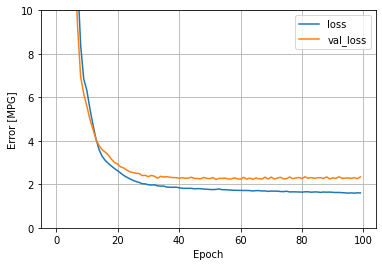

In [10]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [11]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,1.634685


In [38]:
#Test feature line example

In [40]:
test_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,6,232.0,100.0,2634.0,13.0,71,0,0,1


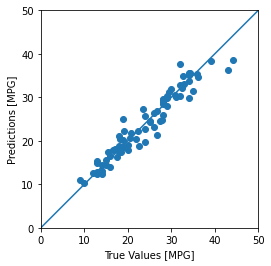

In [12]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

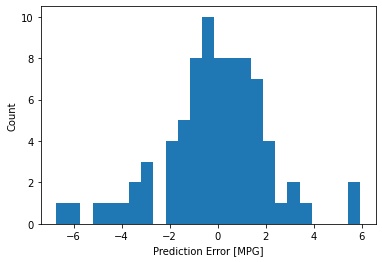

In [13]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [14]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [20]:
reloaded = tf.keras.models.load_model('dnn_model')

In [21]:
test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [22]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]'])

,dnn_model,reloaded
Mean absolute error [MPG],1.634685,1.634685


In [34]:
#SAVE WITH KERAS (IN DIRECTORY FOR SERVING)
import os
import tempfile
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join('./servable', str(version))
print('export_path = {}\n'.format(export_path))


export_path = ./servable/1



In [35]:
tf.keras.models.save_model(
    dnn_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: ./servable/1/assets


In [36]:
print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 140
drwxr-xr-x 2 root root   4096 Apr 29 14:30 assets
-rw-r--r-- 1 root root   8380 Apr 29 14:30 keras_metadata.pb
-rw-r--r-- 1 root root 118808 Apr 29 14:30 saved_model.pb
drwxr-xr-x 2 root root   4096 Apr 29 14:30 variables
